# Resampling Methods

## Left out samples validation

## Cross-validation (CV)

### CV for linaer regression

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import datasets
import sklearn.linear_model as lm
import sklearn.metrics as metrics
from sklearn.model_selection import KFold, StratifiedKFold

In [18]:
X, y = datasets.make_regression(n_samples=100, n_features=100, n_informative=10, random_state=42)

model = lm.Ridge(alpha=10)

cv = KFold(len(y), random_state=42)
y_test_pred = np.zeros(len(y))
y_train_pred = np.zeros(len(y))

for train, test in cv.split(X):
    X_train, X_test, y_train, y_test = X[train, :], X[test, :], y[train], y[test]
    model.fit(X_train, y_train)
    y_test_pred[test] = model.predict(X_test)
    y_train_pred[train] = model.predict(X_train)

print("Train r2: %.2f" % metrics.r2_score(y, y_train_pred))
print("Test  r2: %.2f" % metrics.r2_score(y, y_test_pred))

Train r2: 0.99
Test  r2: 0.84


In [19]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=model, X=X, y=y, cv=5)
print("Test r2:%.2f" % scores.mean())

Test r2:0.73


### CV for classification

In [20]:
X, y = datasets.make_classification(n_samples=100, n_features=100, 
                                    n_informative=10, random_state=42)

model = lm.LogisticRegression(C=1, solver='lbfgs')

cv = StratifiedKFold(n_splits=5)
y_test_pred = np.zeros(len(y))
y_train_pred = np.zeros(len(y))

for train, test in cv.split(X, y):
    X_train, X_test, y_train, y_test = X[train, :], X[test, :], y[train], y[test]
    model.fit(X_train, y_train)
    y_test_pred[test] = model.predict(X_test)
    y_train_pred[train] = model.predict(X_train)

recall_test = metrics.recall_score(y, y_test_pred, average=None)
recall_train = metrics.recall_score(y, y_train_pred, average=None)
acc_test = metrics.accuracy_score(y, y_test_pred)

print("Train SPC:%.2f; SEN:%.2f" % tuple(recall_train))
print("Test SPC:%.2f; SEN:%.2f" % tuple(recall_test))
print("Test ACC:%.2f" % acc_test)

Train SPC:1.00; SEN:1.00
Test SPC:0.78; SEN:0.82
Test ACC:0.80


In [21]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=model, X=X, y=y, cv=5)
scores.mean()

# provide CV and score
def balanced_acc(estimator, X, y):
    '''Balanced acuracy scorer'''
    return metrics.recall_score(y, estimator.predict(X), average=None).mean()

scores = cross_val_score(estimator=model, X=X, y=y, cv=cv, scoring=balanced_acc)
print("Test ACC:%.2f" % scores.mean())

Test ACC:0.80


## CV for model selection: Hyperparameters

In [22]:
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

In [33]:
# Dataset
noise_sd = 10

X, y, coef = datasets.make_regression(n_samples=50, n_features=100, noise=noise_sd, 
                                      n_informative=2, random_state=42, coef=True)

# Use this to tune the noise parameter such that snr < 5
print("SNR:", np.std(np.dot(X, coef)) / noise_sd)

# param grid over alpha & l1_ratio
param_grid = {'alpha': 10. ** np.arange(-3, 3), 'l1_ratio':[.1, .5, .9]}

# Warp
model = GridSearchCV(lm.ElasticNet(max_iter=10000), param_grid, cv=5, iid=False)

# 1) Biased usage: fit on all data, ommit outer CV loop
model.fit(X, y)
print("Train r2:%.2f" % metrics.r2_score(y, model.predict(X)))
print(model.best_params_)

# 2) User made outer CV, useful to extract specific information
cv = KFold(len(y)//5, random_state=42)
y_test_pred = np.zeros(len(y))
y_train_pred = np.zeros(len(y))
alphas = list()

for train, test in cv.split(X):
    X_train, X_test, y_train, y_test = X[train, :], X[test, :], y[train], y[test]
    model.fit(X_train, y_train)
    y_test_pred[test] = model.predict(X_test)
    y_train_pred[train] = model.predict(X_train)
    alphas.append(model.best_params_)

print("Train r2:%.2f" % metrics.r2_score(y, y_train_pred))
print("Test r2:%.2f" % metrics.r2_score(y, y_test_pred))
print("Selected alphas:", alphas)

# 3.) user-friendly sklearn for outer CV
scores = cross_val_score(estimator=model, X=X, y=y, cv=cv)
print("Test r2:%.2f" % scores.mean())

SNR: 2.6358469446381614
Train r2:0.96
{'l1_ratio': 0.9, 'alpha': 1.0}
Train r2:0.97
Test r2:0.74
Selected alphas: [{'l1_ratio': 0.9, 'alpha': 1.0}, {'l1_ratio': 0.9, 'alpha': 0.1}, {'l1_ratio': 0.9, 'alpha': 0.001}, {'l1_ratio': 0.9, 'alpha': 0.001}, {'l1_ratio': 0.9, 'alpha': 1.0}, {'l1_ratio': 0.9, 'alpha': 1.0}, {'l1_ratio': 0.9, 'alpha': 1.0}, {'l1_ratio': 0.9, 'alpha': 1.0}, {'l1_ratio': 0.9, 'alpha': 0.1}, {'l1_ratio': 0.9, 'alpha': 1.0}]
Test r2:0.63


In [37]:
X, y, coef = datasets.make_regression(n_samples=50, n_features=100, noise=10, n_informative=2, random_state=42, coef=True)


print("== Ridge (L2 penalty) ==")
model = lm.RidgeCV(cv=5)
# Let sklearn select a list of alphas with default LOO-CV
scores = cross_val_score(estimator=model, X=X, y=y, cv=5)
print("Test r2:%.2f" % scores.mean())


print("== Lasso (L1 penalty) ==")
model = lm.LassoCV(n_jobs=-1, cv=5)
# Let sklearn select a list of alphas with default 3CV
scores = cross_val_score(estimator=model, X=X, y=y, cv=5)
print("Test r2:%.2f" % scores.mean())


print("== ElasticNet (L1 penalty) ==")
model = lm.ElasticNetCV(l1_ratio=[.1, .5, .9], n_jobs=-1, cv=5)
# Let sklearn select a list of alphas with default 3CV
scores = cross_val_score(estimator=model, X=X, y=y, cv=5)
print("Test r2:%.2f" % scores.mean())

== Ridge (L2 penalty) ==
Test r2:0.20
== Lasso (L1 penalty) ==
Test r2:0.71
== ElasticNet (L1 penalty) ==
Test r2:0.66


In [44]:
X, y = datasets.make_classification(n_samples=100, n_features=100, 
                                    n_informative=10, random_state=42)

# provide CV and score
def balanced_acc(estimator, X, y):
    '''Balanced accuracy scorer'''
    return metrics.recall_score(y, estimator.predict(X), average=None).mean()

print("== Logistic Ridge (L2 penalty) ==")
model = lm.LogisticRegressionCV(class_weight='balanced',n_jobs=-1, cv=5)
# Let sklearn select a list of alphas with default LOO-CV
scores = cross_val_score(estimator=model, X=X, y=y, cv=5)
print("Test ACC:%.2f" % scores.mean())

== Logistic Ridge (L2 penalty) ==
Test ACC:0.78


## Random Permutations

Permutation two tailed p-value=0.06959. Pearson test p-value=0.07355


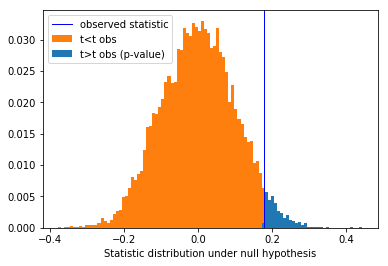

In [49]:
np.random.seed(42)
x = np.random.normal(loc=10, scale=1, size=100)
y = x + np.random.normal(loc=-3, scale=3, size=100) # snr = 1/2

# Permutation: simulate the null hypothesis
nperm = 10000
perms = np.zeros(nperm + 1)

perms[0] = np.corrcoef(x, y)[0, 1]
for i in range(1, nperm):
    perms[i] = np.corrcoef(np.random.permutation(x), y)[0, 1]

# Plot
# Re-weight to obtain distribution
weights = np.ones(perms.shape[0]) / perms.shape[0]
plt.hist([perms[perms >= perms[0]], perms], histtype='stepfilled', bins=100, 
         label=["t>t obs (p-value)", "t<t obs"], weights=[weights[perms >= perms[0]], weights])
plt.xlabel("Statistic distribution under null hypothesis")
plt.axvline(x=perms[0], color='blue', linewidth=1, label="observed statistic")

_ = plt.legend(loc="upper left")

# One-tailed empirical p-value
pval_perm = np.sum(perms >= perms[0]) / perms.shape[0]

# Compare with Pearson's correlation test
_, pval_test = stats.pearsonr(x, y)
print("Permutation two tailed p-value=%.5f. Pearson test p-value=%.5f" % (2*pval_perm, pval_test))

## Bootstrapping

In [ ]:
# Regression dataset
n_features = 5
n_features_info = 2
n_samples = 100
X = np.random.randn(n_samples, n_features)
beta = np.zeros(n_features)
beta[:n_features_info] = 1
Xbeta = np.dot(X, beta)
eps = np.random.randn(n_samples)
y = Xbeta + eps

# Fit model on all data (!! risk of overfit)
model = lm.RidgeCV()
model.fit(X, y)
print("Coefficients on all data:")
print(model.coef_)

# Bootstrap loop
nboot = 100 # !! Should be at least 1000
scores_names = ["r2"]
scores_boot = np.zeros((nboot, len(scores_names)))
coefs_boot = np.zeros((nboot, X.shape[1]))

orig_all = np.arange(X.shape[0])
for boot_i in range(nboot):
    boot_tr = np.random.choice(orig_all, size=len(orig_all), replace=True)
    boot_te = np.setdiff1d(orig_all, boot_tr, assume_unique=False)
    Xtr, ytr = X[boot_tr, :], y[boot_tr]
    Xte, yte = X[boot_te, :], y[boot_te]
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte).ravel()
    scores_boot[boot_i, :] = metrics.r2_score(yte, y_pred)
    coefs_boot[boot_i, :] = model.coef_

# Compute Mean, SE, CI
scores_boot = pd.DataFrame(scores_boot, columns=scores_names)
scores_stat = scores_boot.describe(percentiles=[.99, .95, .5, .1, .05, 0.01])

print("r-squared: Mean=%.2f, SE=%.2f, CI=(%.2f %.2f)" %\
tuple(scores_stat.loc[["mean", "std", "5%", "95%"], "r2"]))

coefs_boot = pd.DataFrame(coefs_boot)
coefs_stat = coefs_boot.describe(percentiles=[.99, .95, .5, .1, .05, 0.01])
print("Coefficients distribution")
print(coefs_stat)